# **Dominant Colors Extraction and Classification**

# Introduction

Colors play a very important role in our everyday life. It is a factor that affects our mood and feelings, our behaviour and even our ability to make decisions $^{[1][2]}$. Each color holds a significant meaning that is determined from both biological and cultural factors $^{[3]}$. Given the fact that our current era is characterized by an abundunce of colored videos and images that take part in almost every aspect of our day to day lives, it safe to assume that colors can be a source of valuable information. This project focuses on the creation of various tools that help with the organization, quantification  and visualization of a big amount of image data in a short time. The functions can extract the dominant colors from the image, it calculates the ratio of each color and names them by one of the 11 basic colors.

\

[1] YILDIRIM, Kemal & Akalın, Aysu & Hidayetoğlu, Mehmet Lutfi. (2007). Effects of indoor color on mood and cognitive performance. Building and Environment.

[2] Kaur, Achint. (2020). A Link Between Colors and Emotions; A Study of Undergraduate Females. International Journal of Engineering Research and. V9.

[3] Viková, Martina & Vik, Michal & Kania, Eva. (2015). Cross-cultural variation of color preferences.

The project is divided into two parts: Dominant color extraction and color naming. The first part utillizes unsupervised learning techniques (KMeans/KMedoids) to cluster the pixels of an image by their RGB values and the second utilizes a supervised classification technique (K-Nearest Neighbors) to name them. For the color clustering, a variety of input images was used to evaluate and calibrate the model and the for the color naming, a dataset of 11 classes (one for each color) was used for the training. 

## About the dataset

The dataset has 11 classes of basic colors based on the color terms defined in English: 'black', 'white', 'red', 'green', 'yellow', 'blue', 'brown', 'orange', 'pink', 'purple', 'grey'. The dataset was collected from a variety of sources but mainly using an online RGB color wheel. During the dataset collection I tried to cover as many caharacteristics (hue, pale, deep, brightness) as possible for every color. Despite that, some concerns still remain. For example, the color category of a lot of hues is not clear and changes from person to person.

\

Link to Dataset: https://drive.google.com/drive/folders/1ykThFttHDvR0Qx6jV7jRAaKQgLfccg1f?usp=sharing

# Mount Drive and Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.0 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from scipy.stats import pearsonr
from tqdm import tqdm
import time
import requests
from io import BytesIO

# Part A: Extract Dominant Colors - Clustering

## Usefull Functions

### Preprocessing

This function takes as input an image and it preprocesses to use in clustering. It checks if the image is RGB and converts it in case it's not and it resizes it while keeping the aspect ratio, so that the biggest side is 50 pixels in length. Finally it returns the resized picture.

In [4]:
def preprocess(img):
  
  print('Processing the image...')

  # Converts image in RGB if it is of different type
  if img.mode != 'RGB':
    print(f'Changing mode from {img.mode} to RGB')
    img = img.convert('RGB')

  # Resizes image if any dimension is greater than 50 pixels
  width, height = img.size
  if width >= height and width > 50:
    new_width = 50
    new_height = round(new_width * height / width)  # Keep aspect ratio
    print(f'Resized from ({width},{height}) to ({new_width},{new_height})')
  elif height > width and height > 50:
    new_height = 50
    new_width = round(new_height * width / height)
    print(f'Resized from ({width},{height}) to ({new_width},{new_height})')

  img = img.resize((new_width, new_height), Image.ANTIALIAS)

  print('     Done!\n')

  return img

### Pixel RGB values extraction

This function takes as input the (resized) image and splits the RGB channels and saves them in a pandas DataFrame which is returned.

In [5]:
def color_extraction(image):
  print('Extracting Data...')
  r, g, b = np.dsplit(np.asarray(image), np.asarray(image).shape[-1])  # Splits image into 3 arrays by depth - 3rd dimension (RGB channels)

  # Create DataFrame
  df = pd.DataFrame({'red': np.array(r).flatten(), 
                    'green': np.array(g).flatten(),
                    'blue': np.array(b).flatten()})

  print('     Done!\n')

  return df

### Find the optimal number of clusters

This function uses KMeans clustering to calculate the inertia for every number of clusters $k$ in the range $[0, max\_clusters]$ and utilizes the elbow method to select the optimal k. The reason that K Means was chosen over K Medoids is that The clusters-inertia function of KMeans is stably decreasing, while the KMedoids fluctuate. Thus, KMeans is a more stable way to calculate the optimal number of clusters using the elbow method and the metrics provided for the calculation of the optimal k. (figure 1)

\

Two metrics can be implemented to chose the "elbow" point ie. the optimal number of clusters: "pearson" and "distance". Briefly, "pearson" finds the point k for which and onward pearson's r between the points of the elbow graph are above a certain threshold and "distance" selects as the point k which is the furtherst away from the line that goes through the second and last point of the graph (figure 2). There is also a parameter for the maximum number of clusters as this is a factor that affects the outcome of both metrics. Images with more colors benefit from larger values of `max_clusters` while images with less benefit from a smaller one. After some experimentation with various images, the default is set to `max_clusters=20`  as that seems to be a good value for most images. Lastly, there is also the option to plot the elbow graph.



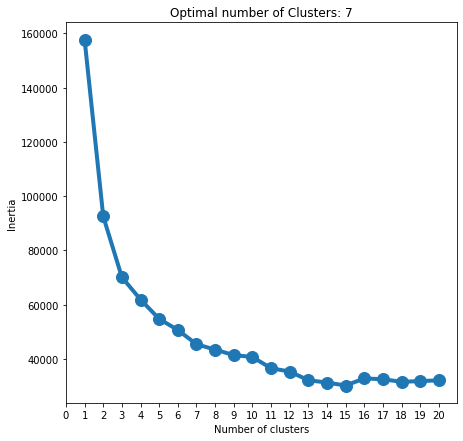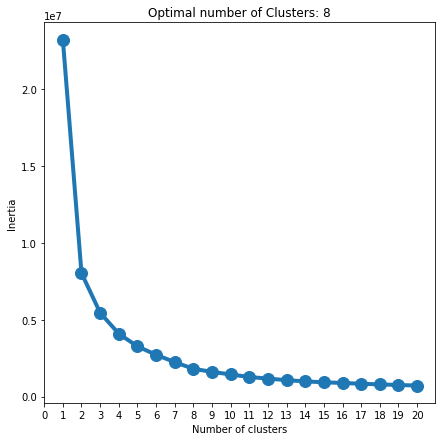

1. KMedoids and KMeans elbow plots respectively



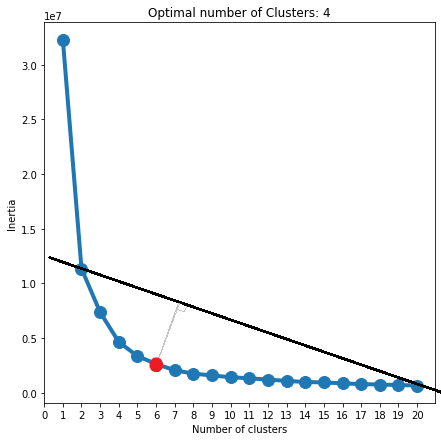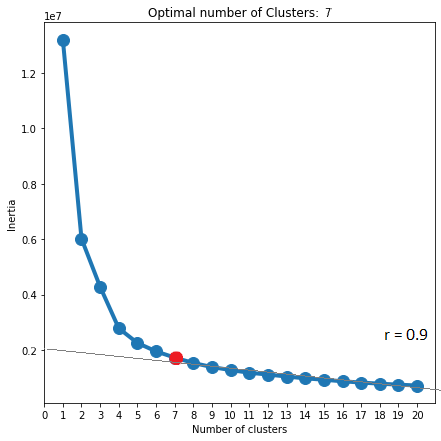


2. Distance and Pearson Metrics respectively

In [6]:
def find_optimal_k(df, metric='distance', plot_elbow=True, max_clusters=20):
  
  print('Applying elbow method...')

  # Compute inertia for each cluster in given range using KMeans.
  inertia = []
  for i in tqdm(range(1, max_clusters+1)):
    cluster_model = KMeans(n_clusters=i)
    cluster_model.fit(df)

    inertia.append(cluster_model.inertia_)

  # Finds the point of the elbow plot from which onward all the points are
  # linearly correlated above the threshold "sensitivity"
  if metric == 'pearson':
    r = 0  # initialization of pearson's r
    j = 0  # index

    while round(abs(r), 2) < pearson_sensitivity and j <= len(inertia)-2:
      X = list(range(j+1, max_clusters+1))
      y = inertia[j:]
      r = pearsonr(X, y)[0]

      j += 1
      
    optimal_k = j-1
    
  # Finds the point of the elbow plot which is the furthest away from the line
  # that passes through the points for k=1 and k=max_clusters 
  elif metric == 'distance':      
    X = list(range(1,max_clusters+1))
    Y = inertia

    P1 = np.array([X[1], Y[1]])
    P2 = np.array([X[-1],Y[-1]])
    max_distance = -1

    for x, y in zip(X[2:], Y[2:]):
      P3 = np.array([x, y])
      distance = abs(np.cross(P2-P1,P3-P1)/np.linalg.norm(P2-P1))

      if distance > max_distance:
        optimal_k = x
        max_distance = distance
  
  if plot_elbow==True:
    graph_elbow(inertia, optimal_k)

  return optimal_k

This is the function where the final clustering happens. It takes as input the dataframe of the pixels' RGB values, the model to use and the number of clusters to find (in our case `optimal_k`) and returns an numpy array of the centroids and the dataframe updated with the cluster label for each pixel.

In [7]:
def cluster(df, k, model='kmedoids'):

  # Select model
  if model == 'kmeans':
    cluster_model =  KMeans(n_clusters=k)
  elif model == 'kmedoids':
    cluster_model = KMedoids(n_clusters=k)

  cluster_model.fit(df)  # Fit to data
  
  labels = cluster_model.labels_  # Get cluster labels
  
  # Change initalization method (bug with heuristic of KMedoids -> UserWarning empty clusters)
  if model == 'kmedoids' and np.max(labels) == np.min(labels) and k != 1:
    print('Changing init from heuristic to k-medoids++')
    cluster_model = KMedoids(n_clusters=k, init='k-medoids++')
    cluster_model.fit(df)
    
    labels = cluster_model.labels_

  centroids = cluster_model.cluster_centers_  # Get centroids of clusters
  df['Labels'] = labels  # Update dataframe with labels

  print('     Done!\n')

  return centroids, df

### Plot the elbow curve

A simple function to plot the elbow graph

In [8]:
def graph_elbow(inertia, optimal_k):
  print('Plotting curve of elbow method...')

  fig = plt.figure(figsize=(7, 7))
  plt.plot(range(1, len(inertia)+1), inertia, linewidth=4, markersize=12, marker='o', color='tab:blue')
  plt.xticks(np.arange(len(inertia)+1))
  plt.xlabel("Number of clusters")
  plt.ylabel("Inertia")
  plt.title(f'Optimal number of Clusters: {optimal_k}')
  plt.show()

### Orders centroids and calculate ratios

Here the clusters centroids are ordered based on the value count of each cluster and the percentage of the image that was grouped in each cluster ie. the ratios between each of the colors/clusters is calculated. Both ordered clusters and ratio are returned.

In [9]:
def order_centroids(df, centroids):
  print('Ordering centroids...')

  ordered_labels = list(df['Labels'].value_counts().keys())
  ordered_counts = list(df['Labels'].value_counts().values)
  ordered_centroids = [centroids[i] for i in ordered_labels]
  ratios = [round(count/len(df)*100) for count in ordered_counts]
  
  print('     Done!\n')

  return ordered_centroids, ratios

### Plot and Save the Colors

Using the function below, the colors are plotted while maintainig the ratio and are then saved

In [10]:
def graph_dominant(centroids, ratios):
  # Size of colors with respect to ratios, ie. Use the ratio to determine how
  # many time each color will be plot
  colors = []
  for c, r in zip(centroids, ratios):
    colors.extend([c] * r)

  print('Dominant colors:')

  # Plot
  fig, ax = plt.subplots(figsize=(20, 5))
  ax.imshow([colors])
  plt.tight_layout()
  plt.axis('off')

In [11]:
def save_fig(image_name):
  # Saves figure
  figure_name = image_name + '_dominant'
  plt.savefig(figure_name, bbox_inches='tight', pad_inches=0)  # Saves figure without whitespace around it
  plt.show()

## Main Function

Even though all the functions above can be used separetely, a main function is defined that combines all of the above. Using this function, it is easy to select the model, the number of clusters, the metric and whether we want the clusters ratioed among other parameters.

In [12]:
def get_dominant_colors(img, k=-1, model='kmedoids', plot_elbow=False, max_clusters=25,
                        metric='distance', plot_dominant_colors=True, color_ratios=False, 
                        pearson_sensitivity=0.95):

  """
  Main function that combines all of the functions above while making easy to 
  specify what we are looking for through parameters.
  -----------------------------------------------------------------------------
  Keyword arguments:

  img ----- the input image that we want to extract the dominant colors

  k ---- the total number of clusters/dominant colors. If k=-1 then the optimal
         number of clusters is selected using the distance metric

  model ---- the preferred clustering model -- 'kmedoids' or 'kmeans'

  plot_elbow ---- whether to graph the elbow curve or not

  max_clusters ---- the maximum number of clusters for the elbow method

  metric ---- the metric to calculate the elbow point

  plot_dominant_colors ---- whether to plot the extracted dominant colors or not

  color_ratios ---- whether to take calculate the ratios and order the centroids

  pearson_sensitivity ---- threshold for pearson's r if metric is 'pearson'
  """

  image = preprocess(img)
  colors_df = color_extraction(image)

  # If the number of clusters is defined, directly find them using the prefered model
  if k != -1:
    if model == 'kmeans':
      cluster_model = KMeans(n_clusters=k)
    elif model == 'kmedoids':
      cluster_model = KMedoids(n_clusters=k)

    cluster_model.fit(colors_df)
    colors_df['Labels'] = cluster_model.labels_
    centroids = cluster_model.cluster_centers_
  else:
    optimal_k = find_optimal_k(colors_df, metric=metric, plot_elbow=plot_elbow, max_clusters=max_clusters)  # Find optimal k
    centroids, colors_df = cluster(colors_df, optimal_k, model=model)  # Calculate centroids and update dataframe
   
  if color_ratios:
    centroids, ratios = order_centroids(colors_df, centroids)  # Order centroids and calculate color ratios
  else:
    ratios = [1]*len(centroids)

  centroids = np.asarray(centroids)/255  # Normalize centroids

  if plot_dominant_colors:
    graph_dominant(centroids, ratios)  # Plot
  
  return centroids, colors_df

## An implementation

In [13]:
#@title Define parameters:
#@markdown Specify image source (or use the demo images)

image_source = "Demo2" #@param ["Url", "Upload", "Path", "Demo1", "Demo2", "Demo3", "Demo4", "Demo5"]

#@markdown Larger sensitivity = More Colors. Realistic photos or images with a 
#@markdown lot colors benefit from bigger sensitivity 
#@markdown (Applies only if `metric = 'pearson'`)
pearson_sensitivity = 0.95 #@param {type:"slider", min:0.7, max:1, step:0.01}

#@markdown Number of clusters/colors. Set to k $=-1$ to let the model chose number of colors
k =  -1 #@param {type:"integer"} # optional choose the nuber of dominant colors to be found

if image_source == "Url":

  url = input("Paste image url here:")
  response = requests.get(url)
  image_path = BytesIO(response.content)
  image_name = os.path.splitext(url)[0]

elif image_source == "Upload":
  from google.colab import files
  image_path = list(files.upload().keys())[0]
  image_name = os.path.splitext(image_path)[0]

elif image_source == "Path":
  image_path = input('Paste image path here:')  
  image_name = os.path.splitext(image_path)[0]

# Best performance: model=kmeans/kmedoids, max_clusters=20, optimal_k_metric=distance
elif image_source == "Demo1":
  url = 'https://play-lh.googleusercontent.com/aFWiT2lTa9CYBpyPjfgfNHd0r5puwKRGj2rHpdPTNrz2N9LXgN_MbLjePd1OTc0E8Rl1'
  response = requests.get(url)
  image_path = BytesIO(response.content)
  image_name = 'Demo1'

# Best performance: model=kmedoids, max_clusters=20, optimal_k_metric=distance
elif image_source == "Demo2":
  url = 'https://cdn.shopify.com/s/files/1/0075/2241/8801/files/queen-colors-1529966974.jpg?v=1635470610'
  response = requests.get(url)
  image_path = BytesIO(response.content)
  image_name = 'Demo2'

# Best performance: model=kmeans, max_clusters=20, optimal_k_metric=pearson/distance
elif image_source == "Demo3":
  url = 'https://www.brickfanatics.com/wp-content/uploads/LEGO-40516-Everyone-is-Awesome-Brickset-review-featured-1200x720.jpg'
  response = requests.get(url)
  image_path = BytesIO(response.content)
  image_name = 'Demo3'

# Best performance: model=kmeans, max_clusters=20, optimal_k_metric=pearson
# Best performance: model=kmeans, max_clusters=25, optimal_k_metric=distance
elif image_source == "Demo4":
  url = 'https://img.freepik.com/free-photo/colorful-powder-explosion-white-background_36326-3082.jpg?w=2000'
  response = requests.get(url)
  image_path = BytesIO(response.content)
  image_name = 'Demo4'

elif image_source == "Demo5":
  url = 'https://www.nyip.edu/images/cms/photo-articles/the-best-place-to-focus-in-a-landscape.jpg'
  response = requests.get(url)
  image_path = BytesIO(response.content)
  image_name = 'Demo5'

**Demo 1**, Best performance: model=kmeans/kmedoids, max_clusters=20, optimal_k_metric=distance

**Demo 2**, Best performance: model=kmedoids, max_clusters=20, optimal_k_metric=distance

**Demo 3**, Best performance: model=kmeans, max_clusters=20, optimal_k_metric=pearson/distance

**Demo 4**, Best performance: 

- model=kmeans, max_clusters=20, optimal_k_metric=pearson

- model=kmeans, max_clusters=25, optimal_k_metric=distance


In [14]:
image = Image.open(image_path)  # Open image

Loading image...


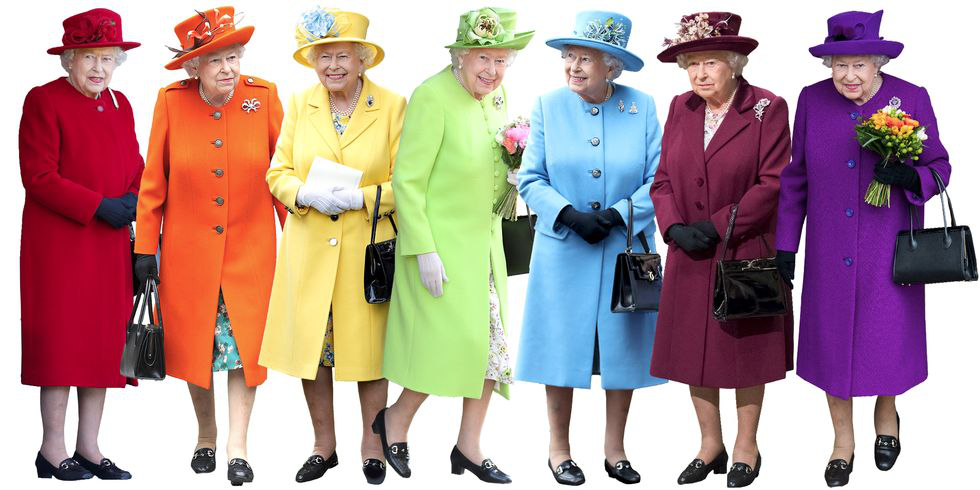

In [15]:
print("Loading image...")
image

Processing the image...
Resized from (980,490) to (50,25)
     Done!

Extracting Data...
     Done!

Applying elbow method...


100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


Plotting curve of elbow method...


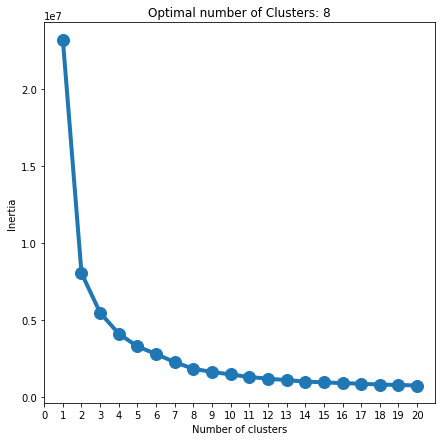

     Done!

Ordering centroids...
     Done!

Dominant colors:


In [16]:
centroids, colors_df = get_dominant_colors(image, 
                                           k=k, 
                                           model='kmedoids', 
                                           plot_elbow=True, 
                                           max_clusters=20, 
                                           plot_dominant_colors=True, 
                                           metric='distance', 
                                           color_ratios=True,
                                           pearson_sensitivity=pearson_sensitivity)

## A more creative Application

Every 100 frames the 2 most dominant colors were extracted from Kubrick's movie "The Shining". The centroids were ordered for each frame and each frames' colors were put next to each other horizontaly and in temporal order. The result is 1028x343 colored "Miniature" of the movie.

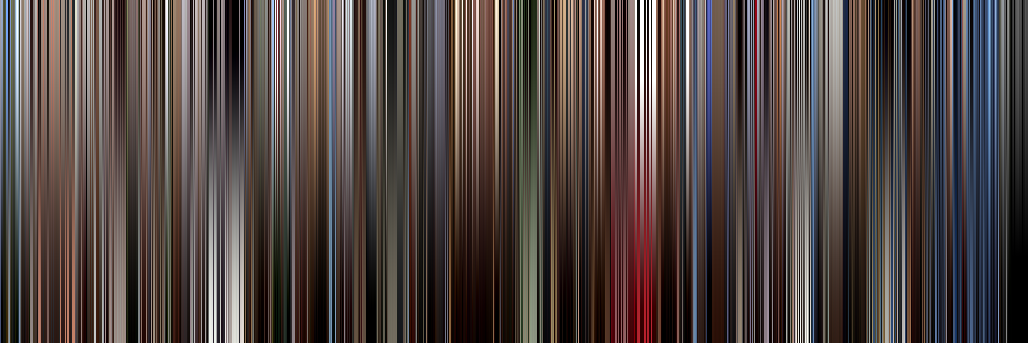

In the created image above we can notice scene changes. For example the red portion of the image is the "Toilet Scene"

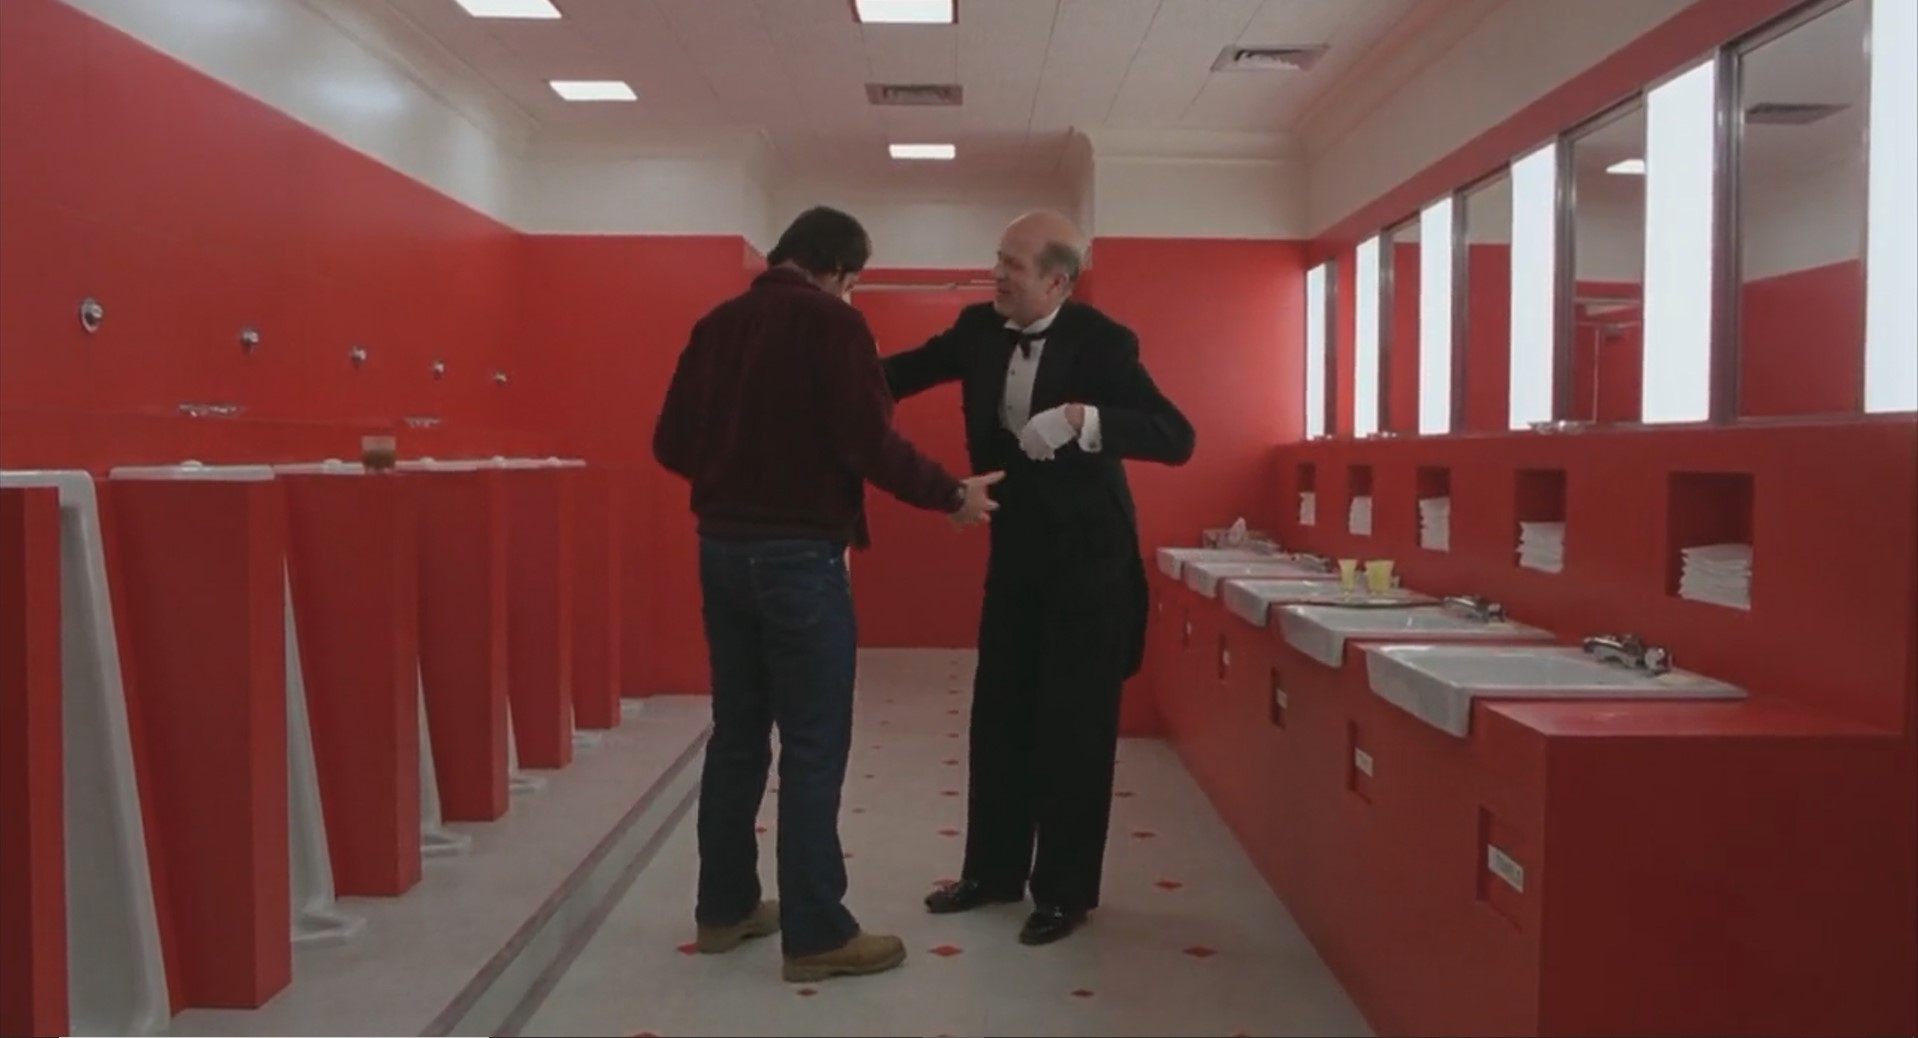

Perhaps one use of the dominant color extraction is to automatically timestamp different scenes in a movie

# Part B: Name the colors - Classification

In [17]:
path = '/content/drive/MyDrive/Colab_Notebooks/AIDL/Data/Color Dataset'

## Extract features

Each training color in the dataset is a solid color meaning that every pixel has the same RGB values. Under these circumstances, feature extraction is just the extraction of the RGB values of any pixel for every color. It is represented as a point in the 3-dimensional Euclidean space.

In [18]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

rgb_values = []  # list to store RGB tuple
labels = []  # list to store labels

# Iterate through folders
for folder in os.listdir(path):
  folder = folder.split('/')[-1]

  # Ensure we're not in root path
  if folder == path.split('/')[-1]:
    continue
  
  print('-'*50, '\n')
  print(f'\nProcessing {folder} colors:')
  print('-'*50, '\n')

  folder_path = os.path.join(path, folder)  # Define folder path
  
  # Iterate through file
  for filename in tqdm(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)  # Define file path
    image = Image.Image.getdata(Image.open(file_path))  # Open image and fetch data

    # Check if RGB and convert if not
    if image.mode != 'RGB':
      print('Converted to RGB')
      image = image.convert('RGB')
    
    image_list = list(image)  # Convert image to list
    rgb_values.append(image_list[1250])  # 1250 is a random pixel
    labels.append(folder)

-------------------------------------------------- 


Processing Yellow colors:
-------------------------------------------------- 



100%|██████████| 142/142 [00:02<00:00, 54.99it/s] 


-------------------------------------------------- 


Processing White colors:
-------------------------------------------------- 



100%|██████████| 88/88 [00:31<00:00,  2.81it/s]


-------------------------------------------------- 


Processing Pink colors:
-------------------------------------------------- 



100%|██████████| 100/100 [00:01<00:00, 68.02it/s]


-------------------------------------------------- 


Processing Red colors:
-------------------------------------------------- 



100%|██████████| 146/146 [00:02<00:00, 69.63it/s] 


Converted to RGB
Converted to RGB
Converted to RGB
Converted to RGB
-------------------------------------------------- 


Processing Grey colors:
-------------------------------------------------- 



100%|██████████| 116/116 [00:01<00:00, 74.21it/s]


-------------------------------------------------- 


Processing Orange colors:
-------------------------------------------------- 



100%|██████████| 136/136 [00:04<00:00, 33.21it/s]


-------------------------------------------------- 


Processing Blue colors:
-------------------------------------------------- 



100%|██████████| 167/167 [00:01<00:00, 100.87it/s]


-------------------------------------------------- 


Processing Purple colors:
-------------------------------------------------- 



100%|██████████| 147/147 [00:01<00:00, 87.63it/s] 


-------------------------------------------------- 


Processing Green colors:
-------------------------------------------------- 



100%|██████████| 167/167 [00:01<00:00, 90.86it/s] 


-------------------------------------------------- 


Processing Brown colors:
-------------------------------------------------- 



100%|██████████| 86/86 [00:30<00:00,  2.85it/s]


-------------------------------------------------- 


Processing Black colors:
-------------------------------------------------- 



100%|██████████| 60/60 [00:20<00:00,  2.92it/s]


In [19]:
import pandas as pd

# Make dataframe of the data
colors_data = pd.DataFrame(rgb_values, columns=['R', 'G', 'B'])
colors_data['Labels'] = labels

In [20]:
colors_data

,R,G,B,Labels
0,252,244,172,Yellow
1,238,239,171,Yellow
2,234,218,17,Yellow
3,240,232,23,Yellow
4,245,241,144,Yellow
...,...,...,...,...
1350,16,13,8,Black
1351,12,16,19,Black
1352,0,4,13,Black
1353,8,12,13,Black


## Explore Data

In [21]:
colors_data['Labels'].value_counts()

Blue      167
Green     167
Purple    147
Red       146
Yellow    142
Orange    136
Grey      116
Pink      100
White      88
Brown      86
Black      60
Name: Labels, dtype: int64

In [22]:
colors = [color.lower() for color in colors_data['Labels'].unique()]
colors[colors.index('white')] = 'whitesmoke'

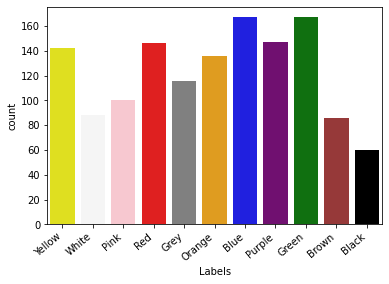

In [23]:
import seaborn as sns

ax = sns.countplot(data=colors_data, x='Labels', palette=colors)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

The dataset is a bit imbalanced since some colors don't have as many hues as others. There aren't any huge differences though and even the least populated classes have enough instances. We will just use stratification at the training process.

In [24]:
import plotly.express as px

color_map = {
             "Blue": "blue",
             "Red": "red",
             "Yellow": "yellow",
             "Green" : "green",
             "Purple": "purple",
             "Grey": "grey",
             "Black": "black",
             "Orange": "orange",
             "White": "whitesmoke",
             "Pink": "pink",
             "Brown": "brown"
             }

fig = px.scatter_3d(colors_data,  x='R', y='G', z='B', color='Labels', color_discrete_map=color_map)
fig.show()

We notice from the 3D plot above that the distribution of the dataset is wide enough to cover most of the range [0, 255] for each of the 3 dimensions (RGB colors). There is an almost empty area at the range [0, 100], [100, 250], [0, 50] for RGB respectively. This area probably contains some hues of green that were not collected in the dataset.

## Split Data

In [25]:
from sklearn.model_selection import train_test_split

X = np.asarray(colors_data[['R','G','B']])
y = colors_data['Labels']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,  random_state=0)

In [26]:
X_train.shape

(948, 3)

In [27]:
X_test.shape

(407, 3)

## Train Classifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [29]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = knn.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred), '\n')
print(classification_report(y_test, y_pred, target_names=colors_data["Labels"].unique()))

Accuracy Score:  0.9926289926289926 

              precision    recall  f1-score   support

      Yellow       1.00      1.00      1.00        18
       White       1.00      1.00      1.00        50
        Pink       0.96      1.00      0.98        26
         Red       1.00      1.00      1.00        50
        Grey       1.00      1.00      1.00        35
      Orange       0.98      0.98      0.98        41
        Blue       1.00      1.00      1.00        30
      Purple       1.00      1.00      1.00        44
       Green       1.00      0.95      0.98        44
       Brown       1.00      1.00      1.00        26
       Black       0.98      1.00      0.99        43

    accuracy                           0.99       407
   macro avg       0.99      0.99      0.99       407
weighted avg       0.99      0.99      0.99       407



We can see that the model seems to be performing very well with an accuracy of 99.2%. From the F1 scores above we can see that Green has a lower recall score than all the other classes. That means that some hues of green were misclassified as other colors (possibly black judging by black's precision). That might hae happened due to the empty green area we noticed earlier.

## Check Results

### Testing the model with 10 randomly generated colors

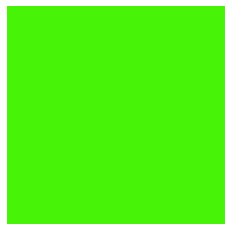

Green


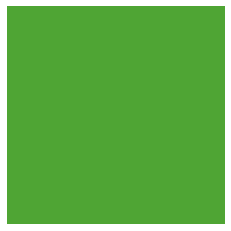

Green


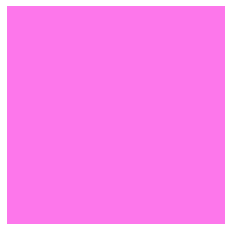

Pink


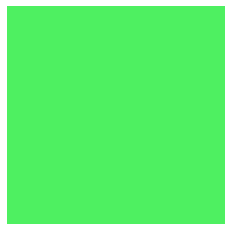

Green


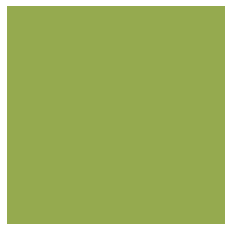

Green


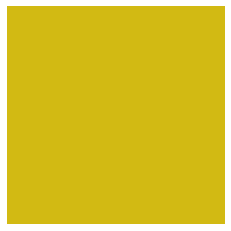

Yellow


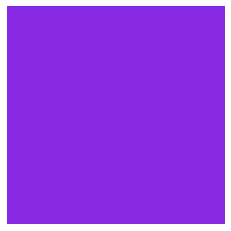

Purple


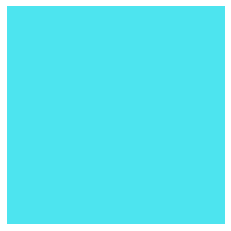

Blue


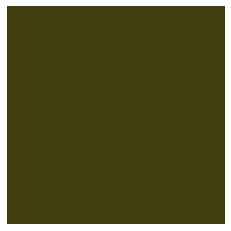

Brown


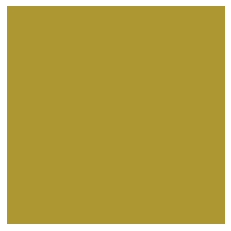

Yellow


In [30]:
import matplotlib.pyplot as plt

for i in range(10):
  test_color = np.array(np.random.choice(range(256), size=3))
  plt.imshow([test_color.reshape(1,3)])
  plt.axis('off')
  plt.show()
  print(knn.predict(test_color.reshape(1,-1))[0])

### Naming the Clusters from the implementation of Part A

We will now name the dominant colors we found in Part A using the classification model.

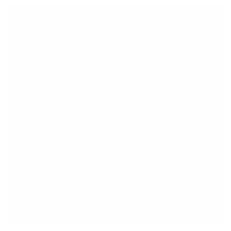

White


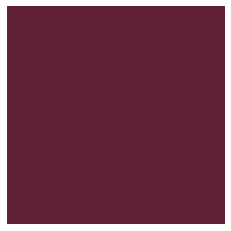

Brown


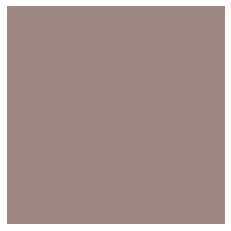

Grey


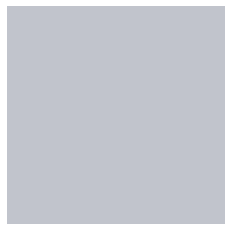

Grey


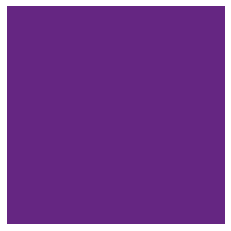

Purple


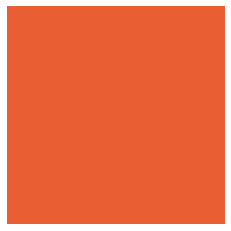

Orange


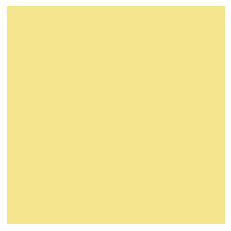

Yellow


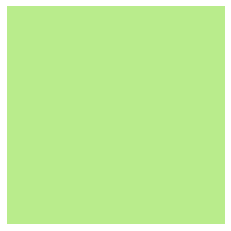

Green


In [31]:
for color in centroids:
  color = (np.round(color*255)).astype('int')
  plt.imshow([color.reshape(1,3)])
  plt.axis('off')
  plt.show()
  print(knn.predict(color.reshape(1,-1))[0])

# Discussion

Even though the both parts of the application seem to be working well with the the tested images, there are still a lot that can be done to improve the performance as well as the flexibility of the process. Quite a few things could be added or changed but it was beyond the scope of this project so a simple mention to them is done here.

First of all, we could extend the `find_optimal_colors` function to use additional methods other than K Means. For example gap statistics. The metrics for the optimal k selection could also be extended. A possibility is for example to use derivatives as another metric. In addition to more metrics, another improvement would be to find a way to change the sensitivity of the `distance` metric. One such idea is to change the number of `max_clusters` or to define different points for the line to go through. For example, greater sensitivity could be achieved with a bigger `max_clusters` parameter or with a line that passes through the further point and the last (instead of second and last). Finally, the model doesn't work with monochromatic images. Even though the final color might look correct when we use K Medoids, the number of clusters is always overestimated.